# PyNET Architecture for Bokeh Effect Simulation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !conda install -c conda-forge gdown
# !pip install -U tensorflow==2.9.1

In [ ]:
# !unzip -q '/content/drive/MyDrive/Training.zip'

In [18]:
OUTPUT_DIR='/kaggle/working'
SAVED_MODEL_FILE='/kaggle/input/pynetweights/pynet.h5'

In [19]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
from tensorflow.keras.initializers import truncated_normal, Constant

In [20]:
gpu = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
def stack(x, y):
    return tf.concat([x, y], axis= 3)

In [22]:
def max_pool(x, n):
    pooling = tfl.MaxPool2D(pool_size=(n, n), strides = (n, n), padding='valid')
    return pooling(x)

In [23]:
def _instance_norm(net):

    batch, rows, cols, channels = [i for i in net.get_shape().as_list()]
    var_shape = [channels]

    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)

    return scale * normalized + shift

In [24]:
def _conv_init_vars(net, out_channels, filter_size, transpose=False):

    _, rows, cols, in_channels = [i for i in net.get_shape()]

    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
    return weights_init

In [25]:
tf.__version__

'2.6.4'

In [26]:
data = tf.constant(np.arange(10).reshape(5, 2) * 10, dtype=tf.float32)
print(data)

tf.Tensor(
[[ 0. 10.]
 [20. 30.]
 [40. 50.]
 [60. 70.]
 [80. 90.]], shape=(5, 2), dtype=float32)


In [27]:
layer = tf.keras.layers.LayerNormalization(axis=[0, 1])
output = layer(data)
output

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-1.5666981 , -1.2185429 ],
       [-0.8703878 , -0.5222327 ],
       [-0.17407757,  0.17407756],
       [ 0.52223265,  0.8703878 ],
       [ 1.2185429 ,  1.5666981 ]], dtype=float32)>

In [28]:
def _conv_layer(net, num_filters, filter_size, strides, relu=True, instance_norm=False, padding='SAME'):

    """weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))"""

    #net = tf.nn.conv2d(net, weights_init, strides_shape, padding=padding) + bias
    layer = tfl.Conv2D(num_filters, kernel_size = filter_size, strides = strides, padding = padding, kernel_initializer = truncated_normal(stddev = 0.01), bias_initializer = Constant(0.01))
    conv = layer(net)
    if instance_norm:
        #conv = _instance_norm(conv)
        conv = tfl.LayerNormalization(axis = [1, 2])(conv)

    if relu:
        conv = tfl.LeakyReLU(alpha = 0.2)(conv)

    return conv

In [29]:
"""input = tf.Variable(tf.constant(np.random.normal(size = (2, 5, 5, 3))))
a = tfl.Conv2DTranspose(5, kernel_size = 3, strides = 1, padding = 'SAME')(input)
b = tf.nn.conv2d_transpose(input, )"""

"input = tf.Variable(tf.constant(np.random.normal(size = (2, 5, 5, 3))))\na = tfl.Conv2DTranspose(5, kernel_size = 3, strides = 1, padding = 'SAME')(input)\nb = tf.nn.conv2d_transpose(input, )"

In [30]:
def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    net_shape = tf.shape(net)
    tf_shape = tf.stack([net_shape[0], net_shape[1] * strides, net_shape[2] * strides, num_filters])

    strides_shape = [1, strides, strides, 1]
    #net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    transpose_layer = tfl.Conv2DTranspose(num_filters, kernel_size = filter_size, strides = strides, padding = 'SAME')
    conv = transpose_layer(net)
    conv = tfl.LeakyReLU(alpha=0.2)(conv)

    return conv

In [31]:
def _conv_multi_block(input, max_size, num_maps, instance_norm):
    conv_3a = _conv_layer(input, num_maps, 3, 1, relu=True, instance_norm=instance_norm)
    conv_3b = _conv_layer(conv_3a, num_maps, 3, 1, relu=True, instance_norm=instance_norm)

    output_tensor = conv_3b

    if max_size >= 5:

        conv_5a = _conv_layer(input, num_maps, 5, 1, relu=True, instance_norm=instance_norm)
        conv_5b = _conv_layer(conv_5a, num_maps, 5, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_5b)

    if max_size >= 7:

        conv_7a = _conv_layer(input, num_maps, 7, 1, relu=True, instance_norm=instance_norm)
        conv_7b = _conv_layer(conv_7a, num_maps, 7, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_7b)

    if max_size >= 9:

        conv_9a = _conv_layer(input, num_maps, 9, 1, relu=True, instance_norm=instance_norm)
        conv_9b = _conv_layer(conv_9a, num_maps, 9, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_9b)

    return output_tensor

In [32]:
def PyNET(input, instance_norm = True, instance_norm_level_1 = False):
    """PyNET Architecture"""
    """Space to depth layer"""
    space_to_depth_layer = tfl.Lambda(lambda x : tf.nn.space_to_depth(x, 2))
    depth = space_to_depth_layer(input)

    # Downsampling layers

    conv_l1_d1 = _conv_multi_block(depth, 3, num_maps=32, instance_norm=False)     # 256 -> 256
    pool1 = max_pool(conv_l1_d1, 2)                                                         # 256 -> 128

    conv_l2_d1 = _conv_multi_block(pool1, 3, num_maps=64, instance_norm=instance_norm)      # 128 -> 128
    pool2 = max_pool(conv_l2_d1, 2)                                                         # 128 -> 64

    conv_l3_d1 = _conv_multi_block(pool2, 3, num_maps=128, instance_norm=instance_norm)     # 64 -> 64
    pool3 = max_pool(conv_l3_d1, 2)                                                         # 64 -> 32

    conv_l4_d1 = _conv_multi_block(pool3, 3, num_maps=256, instance_norm=instance_norm)     # 32 -> 32
    pool4 = max_pool(conv_l4_d1, 2)                                                         # 32 -> 16

    # -----------------------------------------
    # Processing: Level 5,  Input size: 16 x 16

    conv_l5_d1 = _conv_multi_block(pool4, 3, num_maps=512, instance_norm=instance_norm)
    conv_l5_d2 = _conv_multi_block(conv_l5_d1, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d1
    conv_l5_d3 = _conv_multi_block(conv_l5_d2, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d2
    conv_l5_d4 = _conv_multi_block(conv_l5_d3, 3, num_maps=512, instance_norm=instance_norm)

    conv_t4a = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32
    conv_t4b = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32

    # -> Output: Level 5

    conv_l5_out = _conv_layer(conv_l5_d4, 3, 3, 1, relu=False, instance_norm=False)
    output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

    # -----------------------------------------
    # Processing: Level 4,  Input size: 32 x 32

    conv_l4_d2 = stack(conv_l4_d1, conv_t4a)
    conv_l4_d3 = _conv_multi_block(conv_l4_d2, 3, num_maps=256, instance_norm=instance_norm)
    conv_l4_d4 = _conv_multi_block(conv_l4_d3, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d3
    conv_l4_d5 = _conv_multi_block(conv_l4_d4, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d4
    conv_l4_d6 = stack(_conv_multi_block(conv_l4_d5, 3, num_maps=256, instance_norm=instance_norm), conv_t4b)

    conv_l4_d7 = _conv_multi_block(conv_l4_d6, 3, num_maps=256, instance_norm=instance_norm)

    conv_t3a = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64
    conv_t3b = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64

    # -> Output: Level 4

    conv_l4_out = _conv_layer(conv_l4_d7, 3, 3, 1, relu=False, instance_norm=False)
    output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5

    # -----------------------------------------
    # Processing: Level 3,  Input size: 64 x 64

    conv_l3_d2 = stack(conv_l3_d1, conv_t3a)
    conv_l3_d3 = _conv_multi_block(conv_l3_d2, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d2
    conv_l3_d4 = _conv_multi_block(conv_l3_d3, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d3
    conv_l3_d5 = _conv_multi_block(conv_l3_d4, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d4
    conv_l3_d6 = stack(_conv_multi_block(conv_l3_d5, 5, num_maps=128, instance_norm=instance_norm), conv_l3_d1)
    conv_l3_d7 = stack(conv_l3_d6, conv_t3b)

    conv_l3_d8 = _conv_multi_block(conv_l3_d7, 3, num_maps=128, instance_norm=instance_norm)

    conv_t2a = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128
    conv_t2b = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128

    # -> Output: Level 3

    conv_l3_out = _conv_layer(conv_l3_d8, 3, 3, 1, relu=False, instance_norm=False)
    output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5

    # -------------------------------------------
    # Processing: Level 2,  Input size: 128 x 128

    conv_l2_d2 = stack(conv_l2_d1, conv_t2a)
    conv_l2_d3 = stack(_conv_multi_block(conv_l2_d2, 5, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

    conv_l2_d4 = _conv_multi_block(conv_l2_d3, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d3
    conv_l2_d5 = _conv_multi_block(conv_l2_d4, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d4
    conv_l2_d6 = _conv_multi_block(conv_l2_d5, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d5
    conv_l2_d7 = stack(_conv_multi_block(conv_l2_d6, 7, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

    conv_l2_d8 = stack(_conv_multi_block(conv_l2_d7, 5, num_maps=64, instance_norm=instance_norm), conv_t2b)
    conv_l2_d9 = _conv_multi_block(conv_l2_d8, 3, num_maps=64, instance_norm=instance_norm)

    conv_t1a = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256
    conv_t1b = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256

    # -> Output: Level 2

    conv_l2_out = _conv_layer(conv_l2_d9, 3, 3, 1, relu=False, instance_norm=False)
    output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

    # -------------------------------------------
    # Processing: Level 1,  Input size: 256 x 256

    conv_l1_d2 = stack(conv_l1_d1, conv_t1a)
    conv_l1_d3 = stack(_conv_multi_block(conv_l1_d2, 5, num_maps=32, instance_norm=False), conv_l1_d1)

    conv_l1_d4 = _conv_multi_block(conv_l1_d3, 7, num_maps=32, instance_norm=False)

    conv_l1_d5 = _conv_multi_block(conv_l1_d4, 9, num_maps=32, instance_norm=instance_norm_level_1)
    conv_l1_d6 = _conv_multi_block(conv_l1_d5, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d5
    conv_l1_d7 = _conv_multi_block(conv_l1_d6, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d6
    conv_l1_d8 = _conv_multi_block(conv_l1_d7, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d7

    conv_l1_d9 = stack(_conv_multi_block(conv_l1_d8, 7, num_maps=32, instance_norm=False), conv_l1_d1)

    conv_l1_d10 = stack(_conv_multi_block(conv_l1_d9, 5, num_maps=32, instance_norm=False), conv_t1b)
    conv_l1_d11 = stack(conv_l1_d10, conv_l1_d1)

    conv_l1_d12 = _conv_multi_block(conv_l1_d11, 3, num_maps=32, instance_norm=False)

    # -> Output: Level 1

    conv_l1_out = _conv_layer(conv_l1_d12, 3, 3, 1, relu=False, instance_norm=False)
    output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5

    # ----------------------------------------------------------
    # Processing: Level 0 (x2 upscaling),  Input size: 256 x 256

    conv_l0 = _conv_tranpose_layer(conv_l1_d12, 8, 3, 2)        # 256 -> 512
    conv_l0_out = _conv_layer(conv_l0, 3, 3, 1, relu=False, instance_norm=False)
    output_l0 = tf.nn.tanh(conv_l0_out) * 0.58 + 0.5

    # ----------------------------------------------------------
    # Processing: Level Up (x4 upscaling),  Input size: 512 x 512

    conv_l_up = _conv_tranpose_layer(conv_l0_out, 3, 3, 2)  # 512 -> 1024
    conv_l_up_out = _conv_layer(conv_l_up, 3, 3, 1, relu=False, instance_norm=False)

    output_l_up = tf.nn.tanh(conv_l_up_out) * 0.58 + 0.5

    return output_l_up


In [33]:
BATCH_SIZE = 4
input = tf.keras.Input(shape = (512, 512, 3, ))
model  = tf.keras.Model(inputs = input, outputs = PyNET(input))
# model = tf.keras.models.load_model(SAVED_MODEL_FILE, custom_objects = {'Level_1_loss': Level_1_loss})

## Loading and Preprocessing Data

In [34]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Autotune for fetching and parallel processing tasks
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
bokeh_dataset = tf.data.Dataset.list_files('/kaggle/input/bokehdataset/Training/small_bokeh/*.jpg', shuffle = False)
original_dataset = tf.data.Dataset.list_files('/kaggle/input/bokehdataset/Training/small_orig/*.jpg', shuffle = False)
dataset = tf.data.Dataset.zip((original_dataset, bokeh_dataset))
image_count = len(dataset)
print(f"There are {image_count} original-bokeh image pairs in the dataset.")

There are 1200 original-bokeh image pairs in the dataset.


In [36]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, [1024, 1536], method = 'bicubic')
    return img

def process_path(original_path, bokeh_path):
    # Load the raw data from the file as a string
    bokeh_img = tf.io.read_file(bokeh_path)
    original_img = tf.io.read_file(original_path)
    bokeh_img = decode_img(bokeh_img)
    original_img = decode_img(original_img)
    return original_img, bokeh_img

# Convert the dataset from filepaths to image tensors
dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
# Splitting into training and validation datsets
train_dataset = dataset.skip(int(image_count*0.2))
validation_dataset = dataset.take(int(image_count*0.2))

print(f"Training Dataset: {len(train_dataset)} image pairs")
print(f"Validation Dataset: {len(validation_dataset)} image pairs")

Training Dataset: 960 image pairs
Validation Dataset: 240 image pairs


We need random square crops of the image for input and output.

In [38]:
def random_crops(original, bokeh):
    _, h, w, c = original.get_shape().as_list()
    """print(h, w)
    print(batch.get_shape().as_list())
    print(type(batch))"""
    original = original/255.0
    bokeh = bokeh/255.0
    stacked = tf.concat((original, bokeh), axis = -1)
    stacked = tf.image.random_crop(stacked, [BATCH_SIZE, 1024, 1024, 6])
    original, bokeh = tf.split(stacked, num_or_size_splits=2, axis = -1)
    original = tf.image.resize(original, size = [512, 512], method = 'bicubic')
    return original, bokeh

In [39]:
# Resize and crop the dataset for training
def resize_for_training(train_dataset):
    train_dataset = train_dataset.map(random_crops, num_parallel_calls=AUTOTUNE)
    return train_dataset

In [40]:
# Improve performance of the data input pipeline
def configure_for_performance(dataset):
    dataset = dataset.shuffle(100)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [41]:
train_dataset = configure_for_performance(train_dataset)
validation_dataset = configure_for_performance(validation_dataset)

In [42]:
type(train_dataset), len(train_dataset)

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset, 240)

In [43]:
train_dataset = resize_for_training(train_dataset)

In [44]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

# Custom Loss Function (For Level 1)

## VGG Network

In [45]:
# !unzip '/content/drive/MyDrive/VGG.zip'

In [46]:
from scipy.io import loadmat
from tensorflow.keras.losses import MeanSquaredError
vgg_matlab = loadmat('/kaggle/input/bokehdataset/VGG/VGG/imagenet-vgg-verydeep-19.mat')
vgg_weights = vgg_matlab['layers'][0]
layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

In [47]:
IMAGE_MEAN = np.array([123.68,  116.779,  103.939])
def vgg_conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
    return tf.nn.bias_add(conv, bias)

def vgg_net(input_image):
    input_image = input_image - IMAGE_MEAN
    current = input_image
    net = current
    for i, name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels, bias = vgg_weights[i][0][0][0][0]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = vgg_conv_layer(current, kernels, bias)
        elif layer_type == 'relu':
            current = tf.nn.relu(current)
        elif layer_type == 'pool':
            current = tf.nn.max_pool(current, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')
        net = current

    return net

In [48]:
def Level_1_loss(bokeh, target):
    # L1_loss
    # print(f"shape of bokeh {bokeh.get_shape()}")
    # print(f"shape of target {target.get_shape()}")
    l1_loss = tf.abs(tf.subtract(bokeh, target))
    # SSIM loss
    SSIM_loss = tf.reduce_mean(tf.image.ssim(bokeh, target, 1.0))
    # VGG Loss
    bokeh_image_vgg = vgg_net(bokeh*255)
    target_vgg = vgg_net(target*255)
    VGG_loss = MeanSquaredError()(bokeh_image_vgg, target_vgg)
    return l1_loss + (1 - SSIM_loss) + 0.01*VGG_loss

Model Saving Checkpoints

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
save_model = ModelCheckpoint(
    '/kaggle/working/pynet.h5',
    monitor = 'loss',
    save_best_only = True,
    save_weights_only = True,
    verbose = 1
)

In [50]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer = Adam(5e-5),
    loss = Level_1_loss,
    metrics = ['MeanSquaredError']
)

In [51]:
len(train_dataset)

240

In [52]:
# original, bokeh = next(iter(train_dataset))

In [53]:
"""import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
start = 2
for i in range(start, start + 2):
  ax = plt.subplot(2, 2, 2*(i-start) + 1)
  plt.imshow(original[i].numpy().astype("uint8"))
  ax = plt.subplot(2, 2, 2*(i-start) + 2)
  plt.imshow(bokeh[i].numpy().astype("uint8"))"""

'import matplotlib.pyplot as plt\nplt.figure(figsize=(10, 10))\nstart = 2\nfor i in range(start, start + 2):\n  ax = plt.subplot(2, 2, 2*(i-start) + 1)\n  plt.imshow(original[i].numpy().astype("uint8"))\n  ax = plt.subplot(2, 2, 2*(i-start) + 2)\n  plt.imshow(bokeh[i].numpy().astype("uint8"))'

In [54]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config = config)
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [55]:
# !ls /kaggle/working

In [56]:
# model.load_weights(SAVED_MODEL_FILE)
model.load_weights('/kaggle/working/pynet.h5')

In [ ]:
# model.save_weights('./pynet.h5')

In [ ]:
model.fit(
    train_dataset,
    epochs = 4,
    callbacks = [save_model]
)

2023-01-28 09:24:52.087900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2023-01-28 09:25:27.635347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 100
2023-01-28 09:25:32.745332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 77 of 100
2023-01-28 09:25:34.163739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2023-01-28 09:25:49.282153: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-28 09:25:49.511239: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were a

219/240 [==========================>...] - ETA: 50s - loss: 0.3220 - mean_squared_error: 0.0112

In [57]:
validation_dataset = resize_for_training(validation_dataset)


In [58]:
val = validation_dataset.take(1)
import matplotlib.pyplot as plt
for a, b in val:
    global targets
    global renders
    global originals
    originals = a
    renders = model.predict(a)
    targets = b

2023-01-28 11:14:30.718406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


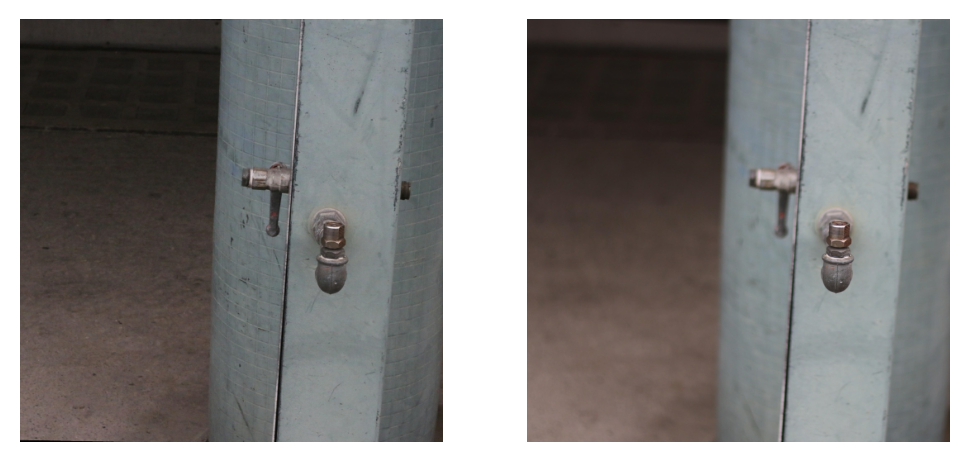

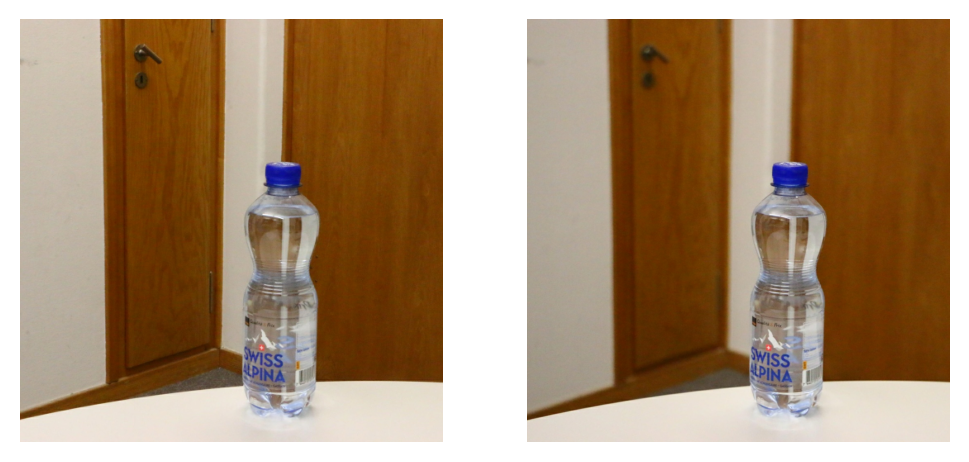

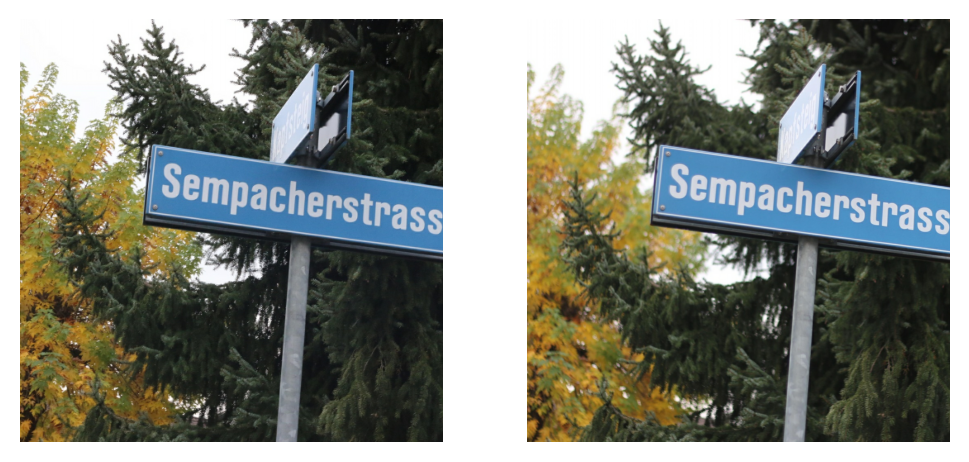

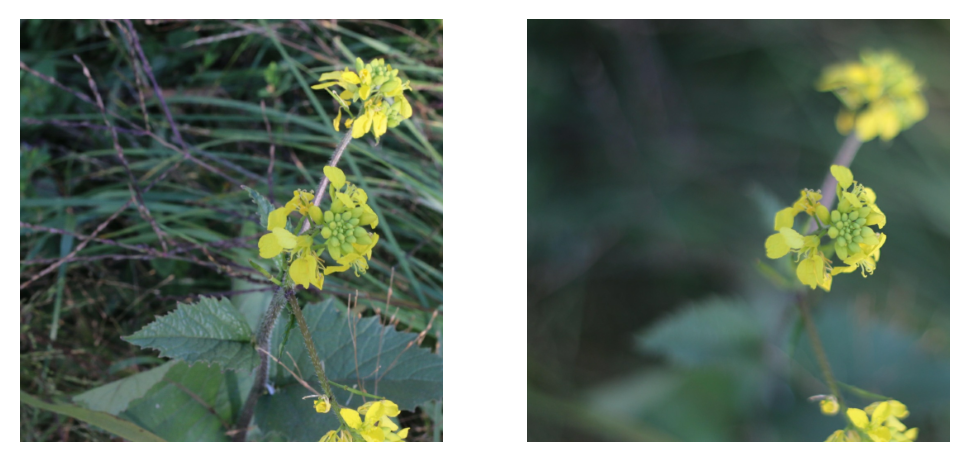

In [59]:
for orig, bokeh in zip(originals, targets):
    plt.figure(dpi = 200)
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(bokeh)
    plt.axis('off')

(1024, 1024, 3) <class 'numpy.ndarray'>
(1024, 1024, 3) <class 'numpy.ndarray'>
(1024, 1024, 3) <class 'numpy.ndarray'>
(1024, 1024, 3) <class 'numpy.ndarray'>


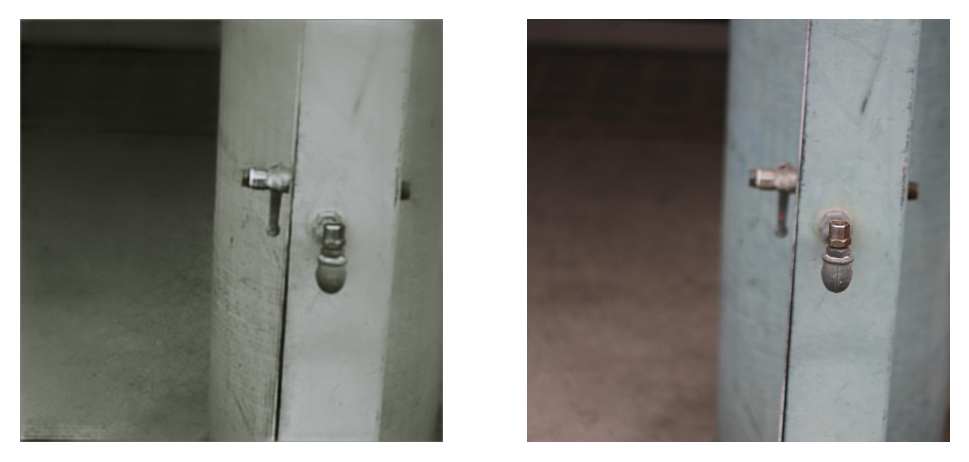

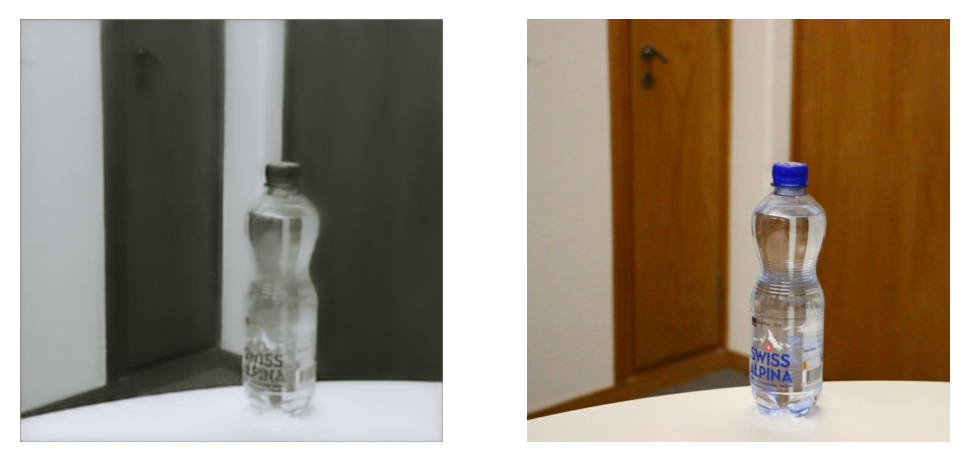

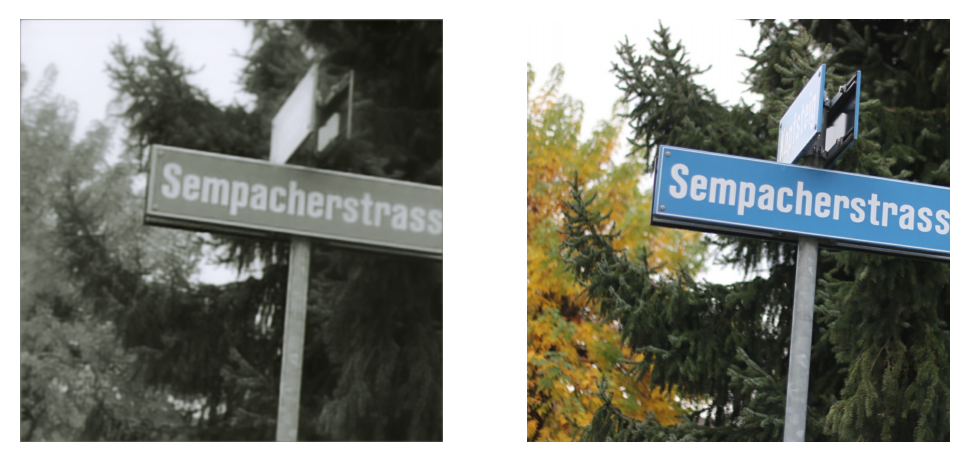

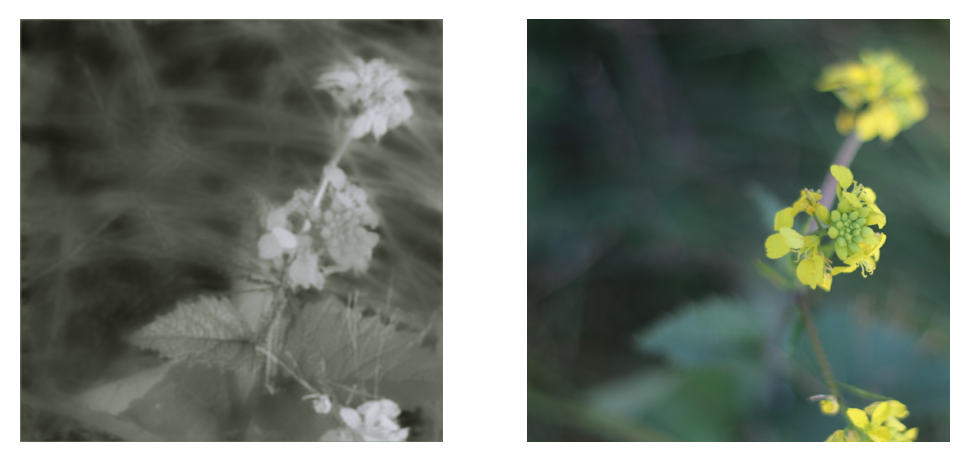

In [60]:
for i, target in zip(range(4), targets):
    plt.figure(dpi = 200)
    plt.subplot(1, 2, 1)
    plt.imshow(renders[i])
    print(np.shape(renders[i]), type(renders[i]))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(target)
    plt.axis('off')